In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/mnt/lun1/home/dbw/anaconda3/envs/cvnets/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 设置设备为GPU（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义超参数
num_epochs = 50
batch_size = 128
learning_rate = 0.001

In [3]:
# 加载和预处理CIFAR-10数据集
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 定义Vision Transformer模型
class VisionTransformer(nn.Module):
    def __init__(self, num_classes=10, image_size=32, patch_size=4, hidden_dim=128, num_heads=8, num_layers=2):
        super(VisionTransformer, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding=2) # 28x28
        self.pool1 = nn.MaxPool2d(2, 2) # 14x14
        self.conv2 = nn.Conv2d(6, 16, 5, padding=2) # 10x10
        self.pool2 = nn.MaxPool2d(2, 2) # 5x5
        self.conv3 = nn.Conv2d(16, 128, 5)

        # self.embedding = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads), num_layers)
        self.fc = nn.Linear(2048, 1024)
        self.fc1 = nn.Linear(1024,128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        out = self.conv1(x) #24
        out = F.relu(out)
        out = self.pool1(out)  #12
        out = self.conv2(out) #10
        out = F.relu(out)
        out = self.pool2(out)
        out = self.conv3(out)
        
        # out = F.interpolate(out, size=(32, 32), mode='bilinear', align_corners=False)
        # out = self.embedding(x)
        out = out.flatten(2).permute(2, 0, 1)
        out = self.transformer(out)
        out = out.permute(1, 0, 2).flatten(1)
        
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [5]:
# # 定义Vision Transformer模型
# class VisionTransformer(nn.Module):
#     def __init__(self, num_classes=10, image_size=32, patch_size=4, hidden_dim=128, num_heads=8, num_layers=2):
#         super(VisionTransformer, self).__init__()
        
#         self.embedding = nn.Conv2d(3, hidden_dim, kernel_size=patch_size, stride=patch_size)
#         self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads), num_layers)
#         self.fc = nn.Linear(hidden_dim * (image_size // patch_size) ** 2, num_classes)

#     def forward(self, x):
#         x = self.embedding(x)
#         x = x.flatten(2).permute(2, 0, 1)
#         x = self.transformer(x)
#         x = x.permute(1, 0, 2).flatten(1)
#         x = self.fc(x)
#         return x

In [6]:
# 初始化VIT模型
model = VisionTransformer().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 定义记录训练损失、测试损失和准确度的列表
train_loss_list = []
test_loss_list = []
accuracy_list = []

In [7]:
# model.load_state_dict(torch.load('doublevit.pth'))

In [8]:
# 训练模型
total_step = len(train_loader)
for epoch in range(num_epochs):
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        if (i + 1) % 100 == 0:
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    # 计算平均训练损失
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)

    # 测试模型
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss +=  loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算平均测试损失和准确度
    test_loss /= len(test_loader)
    test_loss_list.append(test_loss)
    accuracy = 100 * correct / total
    accuracy_list.append(accuracy)

    print("Epoch [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(epoch + 1, num_epochs, test_loss, accuracy))



Epoch [1/50], Step [100/391], Loss: 2.0703
Epoch [1/50], Step [200/391], Loss: 1.9132
Epoch [1/50], Step [300/391], Loss: 1.7719
Epoch [1/50], Test Loss: 1.5773, Test Accuracy: 43.12%
Epoch [2/50], Step [100/391], Loss: 1.6099
Epoch [2/50], Step [200/391], Loss: 1.3077
Epoch [2/50], Step [300/391], Loss: 1.4363
Epoch [2/50], Test Loss: 1.3579, Test Accuracy: 50.46%
Epoch [3/50], Step [100/391], Loss: 1.2897
Epoch [3/50], Step [200/391], Loss: 1.4515
Epoch [3/50], Step [300/391], Loss: 1.2282
Epoch [3/50], Test Loss: 1.2042, Test Accuracy: 57.14%
Epoch [4/50], Step [100/391], Loss: 1.0878
Epoch [4/50], Step [200/391], Loss: 1.1308
Epoch [4/50], Step [300/391], Loss: 1.0765
Epoch [4/50], Test Loss: 1.1347, Test Accuracy: 59.04%
Epoch [5/50], Step [100/391], Loss: 1.1656
Epoch [5/50], Step [200/391], Loss: 1.0982
Epoch [5/50], Step [300/391], Loss: 1.2231
Epoch [5/50], Test Loss: 1.0813, Test Accuracy: 62.12%
Epoch [6/50], Step [100/391], Loss: 1.0456
Epoch [6/50], Step [200/391], Loss: 1

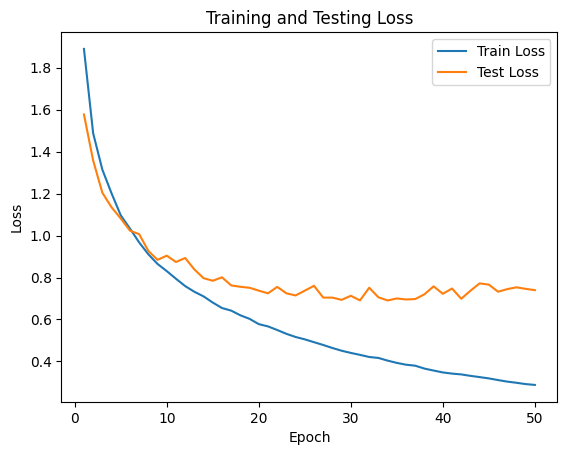

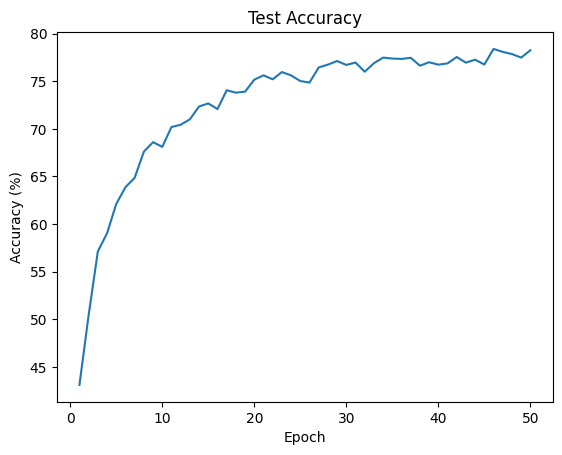

In [9]:
# 绘制训练损失和测试损失曲线
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# 绘制准确度曲线
plt.plot(range(1, num_epochs + 1), accuracy_list)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.show()

In [10]:
# 保存模型参数
torch.save(model.state_dict(), '6LeNet_ViT2.pth')